# Overview & Goals

One of the overarching goals of Kùzu is to function as the go-to graph database for data science use cases. NetworkX is a popular library in Python for graph algorithms and data science. In this notebook, we demonstrate Kùzu's ease of use in exporting subgraphs to the NetworkX format using the `get_as_networkx()` function. In addition, the following two capabilities are demonstrated.

* Graph Visualization: In the first part, we simply draw the nodes and edges in the results using NetworkX.
*  PageRank: In the second part, we compute PageRank on an extracted subgraph of nodes and edges; store these values back in Kùzu's node tables and query them.

## MovieLens Dataset
We will be working on the popular MovieLens dataset from [GroupLens](https://grouplens.org/datasets/movielens/). The schema of the dataset is illustrated as below:

<img src="https://kuzudb.com/data/movie-lens/schema.png" width="500px">

We use the small version of the dataset, which contains 610 `user` nodes, 9724 `movie` nodes, 100863 `rates` edges, and 3684 `tags` edges.

Necessary Package Installations and Imports





In [2]:
!pip install kuzu scipy networkx pandas
!pip install matplotlib ipywidgets yfiles-jupyter-graphs

In [3]:
import kuzu
import pandas as pd
import networkx as nx

Wget Dataset Files and Import Into Kùzu

In [4]:
!rm -rf *.csv ml-small_db

In [8]:
!curl https://kuzudb.com/data/movie-lens/movies.csv >movies.csv 
!curl https://kuzudb.com/data/movie-lens/users.csv  >users.csv
!curl https://kuzudb.com/data/movie-lens/ratings.csv >ratings.csv
!curl https://kuzudb.com/data/movie-lens/tags.csv >tags.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  520k    0  520k    0     0  2653k      0 --:--:-- --:--:-- --:--:-- 2670k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2338    0  2338    0     0  27929      0 --:--:-- --:--:-- --:--:-- 28168
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2327k    0 2327k    0     0  13.1M      0 --:

Create schemas in Kùzu and import the unzipped csv files into Kùzu using COPY FROM clause.

In [9]:
import shutil

db_path = './ml-small_db'
shutil.rmtree(db_path, ignore_errors=True)

def load_data(connection):
    connection.execute('CREATE NODE TABLE Movie (movieId INT64, year INT64, title STRING, genres STRING, PRIMARY KEY (movieId))')
    connection.execute('CREATE NODE TABLE User (userId INT64, PRIMARY KEY (userId))')
    connection.execute('CREATE REL TABLE Rating (FROM User TO Movie, rating DOUBLE, timestamp INT64)')
    connection.execute('CREATE REL TABLE Tags (FROM User TO Movie, tag STRING, timestamp INT64)')

    connection.execute('COPY Movie FROM "./movies.csv" (HEADER=TRUE)')
    connection.execute('COPY User FROM "./users.csv" (HEADER=TRUE)')
    connection.execute('COPY Rating FROM "./ratings.csv" (HEADER=TRUE)')
    connection.execute('COPY Tags FROM "./tags.csv" (HEADER=TRUE)')

db = kuzu.Database(db_path)
conn = kuzu.Connection(db)
load_data(conn)

### Example 1: Graph Visualization with NetworkX

Extract a subgraph of 250 ratings edges using Cypher; convert to a NetworkX graph G; and draw a node-link visualization.



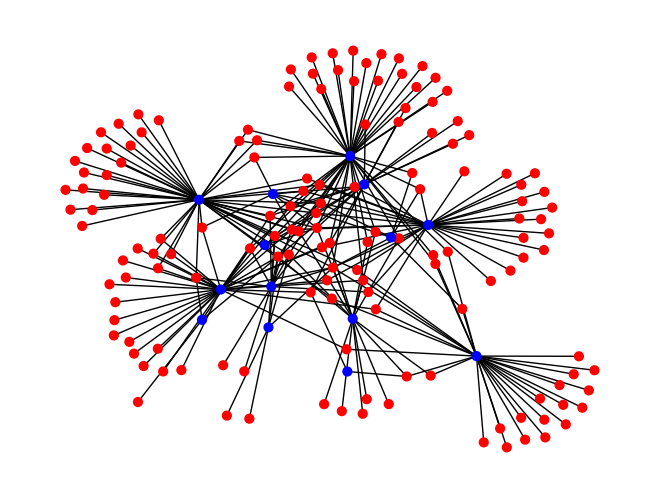

In [10]:
res = conn.execute('MATCH (u:User)-[r:Rating]->(m:Movie) RETURN u, r, m LIMIT 250')
G = res.get_as_networkx(directed=False)
colors = ['red' if G.nodes[node]['_label'] == 'User' else 'blue' for node in list(G.nodes())]
nx.draw_spring(G, node_color=colors, node_size=40)

### Example 2: Interactive graph visualization with yWorks

[yfiles-jupyter-graphs](https://github.com/yWorks/yfiles-jupyter-graphs) is a free tool to generate interactive visualizations of graphs within a Jupyter notebook environment. Follow the [docs](https://github.com/yWorks/yfiles-jupyter-graphs?tab=readme-ov-file#installation) to install the dependencies.

The following visualization uses the same graph G from above that consists of 250 movie ratings edges.

In [11]:
try:
  import google.colab
  from google.colab import output
  output.enable_custom_widget_manager()
except:
  pass

In [12]:
from typing import Union, Any

def custom_node_color_mapping(node: dict[str, Any]):
    """let the color be orange or blue if the index is even or odd respectively"""
    return ("#eb4934" if node['properties']['_label'] == "User" else "#2456d4")

In [14]:
from yfiles_jupyter_graphs import GraphWidget

w = GraphWidget(graph=G)
w.set_sidebar(enabled=False)
w.set_node_color_mapping(custom_node_color_mapping)
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

### Example 3: Compute PageRank, Store Back in the Database and Query

We extract only the subgraph between users and movies (so ignoring tags) and convert to a NetworkX graph G.

In [15]:
res = conn.execute('MATCH (u:User)-[r:Rating]->(m:Movie) RETURN u, r, m')
G = res.get_as_networkx(directed=False)

Next compute PageRanks of users and movies.

In [16]:
pageranks = nx.pagerank(G)

Put returned pageranks into a page_rank_df dataframe and get a list of movies and their pageranks into a movie_df data frame.

In [17]:
pagerank_df = pd.DataFrame.from_dict(pageranks, orient="index", columns=["pagerank"])
movie_df = pagerank_df[pagerank_df.index.str.contains("Movie")]
movie_df.index = movie_df.index.str.replace("Movie_", "").astype(int)
movie_df = movie_df.reset_index(names=["id"])
print(f"Calculated pageranks for {len(movie_df)} nodes")
movie_df.sort_values(by="pagerank", ascending=False).head()

Calculated pageranks for 9724 nodes


,id,pagerank
5321,356,0.001155
5284,318,0.001099
5264,296,0.001075
7281,2571,0.001006
6091,593,0.000987


In [18]:
user_df = pagerank_df[pagerank_df.index.str.contains("User")]
user_df.index = user_df.index.str.replace("User_", "").astype(int)
user_df = user_df.reset_index(names=["id"])
user_df.sort_values(by="pagerank", ascending=False).head()

,id,pagerank
0,599,0.016401
6,414,0.014711
64,474,0.014380
180,448,0.012942
101,610,0.008492


## Update node schemas with pagerank property

Alter the movie and user table schemas by adding a new pagerank property to them (of type float64).

In [19]:
try:
  # Alter original node table schemas to add pageranks
  conn.execute("ALTER TABLE Movie ADD pagerank DOUBLE DEFAULT 0.0;")
  conn.execute("ALTER TABLE User ADD pagerank DOUBLE DEFAULT 0.0;")
except RuntimeError:
  # If the column already exists, do nothing
  pass

## Scan Pandas DataFrame and copy values to Kùzu

The next feature demonstrated is a powerful one: Kùzu can natively scan Pandas DataFrames in a zero-copy manner, by using the `LOAD FROM` clause on the variable name that stores the DataFrame. Once the scan is done, the values are accessible by Kùzu via Cypher. This approach is used to read the computed pageranks (which are in a Pandas DataFrame) to the respective node tables in Kùzu.

In [ ]:
# Copy pagerank values to movie nodes
x = conn.execute(
  """
  LOAD FROM movie_df
  MERGE (m:Movie {movieId: id})
  ON MATCH SET m.pagerank = pagerank
  RETURN m.movieId AS movieId, m.pagerank AS pagerank;
  """
)
x.get_as_df().head()


In [ ]:
# Copy user pagerank values to user nodes
y = conn.execute(
  """
  LOAD FROM user_df
  MERGE (u:User {userId: id})
  ON MATCH SET u.pagerank = pagerank
  RETURN u.userId As userId, u.pagerank AS pagerank;
  """
)
y.get_as_df().head()

We next find the top 20 pagerank movies and then users.

In [ ]:
conn.execute('MATCH (m:Movie) RETURN m.title, m.pagerank ORDER BY m.pagerank DESC LIMIT 10').get_as_df()

In [ ]:
conn.execute('MATCH (u:User) RETURN u.userId, u.pagerank ORDER BY u.pagerank DESC LIMIT 10').get_as_df()

As a final example, we find the average ratings from a highly influential (i.e, high pagerank score) user and highly influential movies. To filter high pagerank users, we first set a threshold of a user's score being above or below the top 10 pagerank scores for all users. Any user with a pagerank score above this value is considered an "influential" user. We repeat this same computation to find the threshold for movies. Then we find all ratings between influential users and movies and take their average.

In [ ]:
user_pr_threshold = conn.execute(
  """
  MATCH (u:User)
  WITH u.pagerank AS user_pr_threshold
  ORDER BY u.pagerank DESC LIMIT 10
  RETURN min(user_pr_threshold)
  """
).get_as_df().iloc[0,0];
user_pr_threshold

In [ ]:
movie_pr_threshold = conn.execute(
    """
    MATCH (m:Movie)
    WITH m.pagerank AS movie_pr_threshold
    ORDER BY m.pagerank DESC LIMIT 10
    RETURN min(movie_pr_threshold)
    """
).get_as_df().iloc[0,0];
movie_pr_threshold

In [ ]:
avg_rating_df = conn.execute(
    """
    MATCH (u:User)-[r:Rating]->(m:Movie)
    WHERE u.pagerank > $user_pr_threshold  AND m.pagerank > $movie_pr_threshold
    RETURN avg(r.rating) as avgRBtwHighPRUserMovies;
    """,
    parameters={"user_pr_threshold": user_pr_threshold, "movie_pr_threshold": movie_pr_threshold}
).get_as_df()
avg_rating_df.head()